<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/part/RO1_SO1_Identification_Part_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research objective - Identification, Sub-objective - Species

This notebook contributes to the first research objective - fish identification. It addresses the first sub-objective - mutli-class classification of fish species.

## Classification methods

This notebook explores traditional machine learning methods for the fish species binary classification task, to elucidate suitable techniques for application in this task.

In [1]:
!pip install skfeature-chappers

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
run = 1
seed = 1617 * run
np.random.seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)

# Load the dataset
data = pd.read_excel(path)

print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
# Binary encodings for class labels (1 for Hoki, 0 for Mackeral)
y = data['m/z'].apply(lambda x: 1 if 'H' in x else 0)
y = np.array(y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Reading the dataset.


In [5]:
X.shape

(234, 1023)

In [6]:
from prettytable import PrettyTable

def show_results(results, label='Technique'):
    table = PrettyTable([label, 'Train Mean', 'Train Std', 'Test Mean', 'Test Std'])

    for name, result in results.items():
        train, test = list(zip(*result))
        vals = [np.mean(train), np.std(train), np.mean(test), np.std(test)]
        row = ['%.4f' % elem for elem in vals ]
        table.add_row(np.concatenate([[name], row]))

    print('\n') # tqdm messses with table border.
    print(table)

def boxplot_results(results):
    # Convert the dictionary to a DataFrame for Seaborn
    data = {'Technique': [], 'Accuracy': [], 'Set': []}

    for technique, runs in results.items():
        train, test = zip(*runs)
        for run in range(1, 31):  # 30 runs
            data['Technique'].append(technique)
            data['Accuracy'].append(train[run - 1])
            data['Set'].append('Train')

            data['Technique'].append(technique)
            data['Accuracy'].append(test[run - 1])
            data['Set'].append('Test')

    df = pd.DataFrame(data)

    # Create a box and whisker plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    sns.boxplot(x='Technique', y='Accuracy', hue='Set', data=df, width=0.6, palette="Set3")
    plt.title('Box and Whisker Plot of Train and Test Accuracies (30 runs each)')
    plt.ylabel('Accuracy')
    plt.xlabel('Technique')
    plt.legend(title='Set')
    plt.show()

In [7]:
# from sklearn.preprocessing import MinMaxScaler

# from skfeature.function.similarity_based import reliefF
# from skfeature.function.information_theoretical_based import MRMR
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest
# from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import LinearSVC as svm
# from sklearn.metrics import balanced_accuracy_score

# def normalize(X_train, X_test):
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler = scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
#     return X_train, X_test

# runs=30
# methods = { "reliefF" : reliefF.reliefF, "mrmr": MRMR.mrmr, "chi2": chi2 } #, "pso": pso}
# results = { "reliefF" : [], "mrmr": [], "chi2": [] }# , "pso": []}
# penalty = 'l1'

# for i in tqdm(range(runs)):
#     for name, fs_method in methods.items():
#         train_accs = []
#         test_accs = []
#         skf = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

#         for train, test in skf.split(X, y):
#             X_train, X_test = (X[train], X[test])
#             y_train, y_test = y[train], y[test]
#             X_train, X_test = normalize(X_train, X_test)

#             fs = SelectKBest(fs_method, k=500)
#             X_train = fs.fit_transform(X_train, y_train)
#             X_test = fs.transform(X_test)

#             model = svm(penalty='l1', dual=(penalty=='l2'), max_iter=10_000)
#             clf = model.fit(X_train, y_train)

#             y_predict = model.predict(X_train)
#             train_acc = balanced_accuracy_score(y_train, y_predict)
#             train_accs.append(train_acc)
#             y_predict = model.predict(X_test)
#             test_acc = balanced_accuracy_score(y_test, y_predict)
#             test_accs.append(test_acc)

#             results[name].append((train_acc, test_acc))

# show_results(results, label='FS Method')

100%|██████████| 30/30 [02:44<00:00,  5.50s/it]




+------------+------------+-----------+-----------+----------+
| Classifier | Train Mean | Train Std | Test Mean | Test Std |
+------------+------------+-----------+-----------+----------+
|    knn     |   0.9689   |   0.0056  |   0.9422  |  0.0497  |
|     rf     |   1.0000   |   0.0000  |   0.9872  |  0.0244  |
|     dt     |   1.0000   |   0.0000  |   0.9942  |  0.0147  |
|     nb     |   0.9316   |   0.0124  |   0.8926  |  0.0621  |
|    svm     |   1.0000   |   0.0000  |   0.9913  |  0.0174  |
+------------+------------+-----------+-----------+----------+


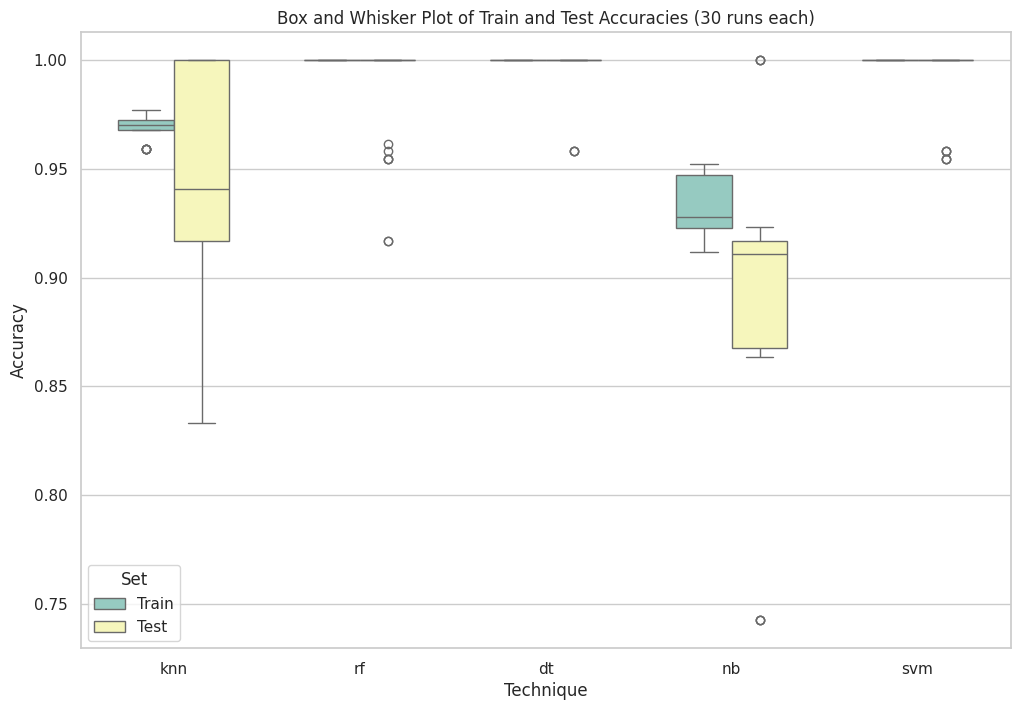

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import LinearSVC as svm
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.metrics import balanced_accuracy_score

def normalize(X_train, X_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

models = {'knn': knn, 'rf': rf, 'dt': dt, 'nb': nb, 'svm': svm}
results = {'knn': [], 'rf': [], 'dt': [], 'nb': [],'svm': []}

for _ in tqdm(range(30)):
    skf = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)
    for train, test in skf.split(X, y):
        X_train, X_test = (X.iloc[train], X.iloc[test])
        y_train, y_test = y[train], y[test]
        X_train, X_test = normalize(X_train, X_test)

        for name, model in  models.items():
            model = model()
            clf = model.fit(X_train, y_train)
            y_predict = model.predict(X_train)
            train_acc = balanced_accuracy_score(y_train, y_predict)
            y_predict = model.predict(X_test)
            test_acc = balanced_accuracy_score(y_test, y_predict)
            results[name].append((train_acc, test_acc))

show_results(results, label='Classifier')
boxplot_results(results)

100%|██████████| 30/30 [01:05<00:00,  2.19s/it]




+----------+------------+-----------+-----------+----------+
| SVM Type | Train Mean | Train Std | Test Mean | Test Std |
+----------+------------+-----------+-----------+----------+
|   svc    |   1.0000   |   0.0000  |   0.9753  |  0.0333  |
|  nusvc   |   0.9883   |   0.0050  |   0.9554  |  0.0418  |
|   lsvc   |   1.0000   |   0.0000  |   0.9913  |  0.0174  |
+----------+------------+-----------+-----------+----------+


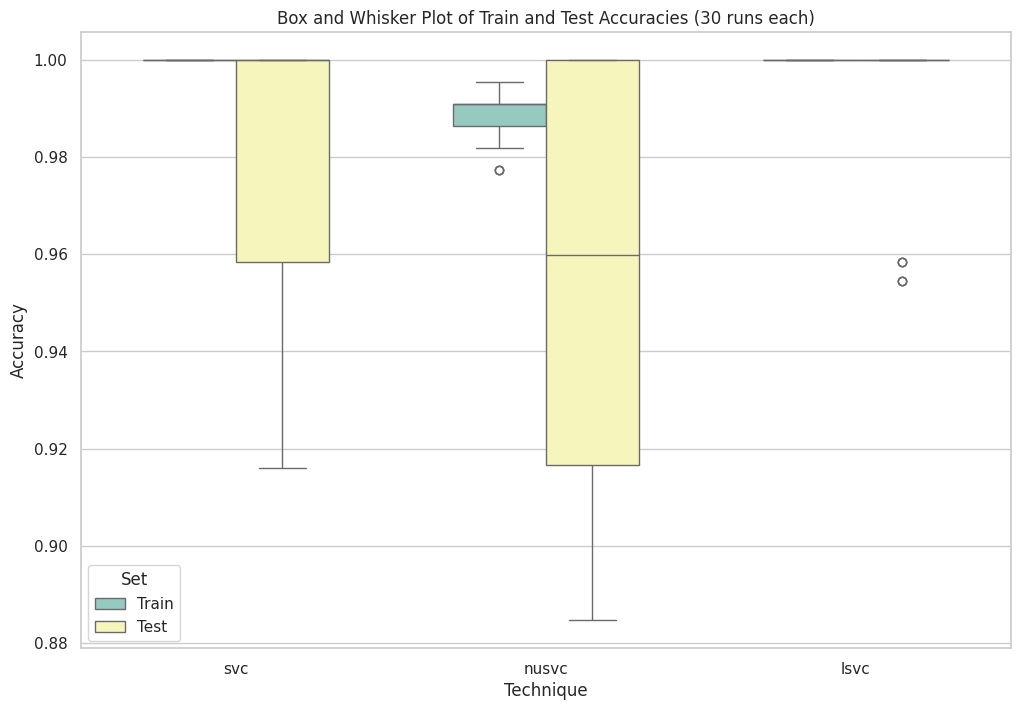

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC as svc
from sklearn.svm import LinearSVC as lsvc
from sklearn.svm import NuSVC as nusvc
from sklearn.svm import LinearSVR as lsvr

models = {'svc': svc, 'nusvc': nusvc, 'lsvc': lsvc,}
results = {'svc': [], 'nusvc': [], 'lsvc': []}

for _ in tqdm(range(30)):
    skf = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)
    for train, test in skf.split(X, y):
        X_train, X_test = (X.iloc[train], X.iloc[test])
        y_train, y_test = y[train], y[test]
        X_train, X_test = normalize(X_train, X_test)

        for name, model in  models.items():
            model = model()
            clf = model.fit(X_train, y_train)
            y_predict = model.predict(X_train)
            train_acc = balanced_accuracy_score(y_train, y_predict)
            y_predict = model.predict(X_test)
            test_acc = balanced_accuracy_score(y_test, y_predict)
            results[name].append((train_acc, test_acc))

show_results(results, label='SVM Type')
boxplot_results(results)

100%|██████████| 30/30 [00:39<00:00,  1.32s/it]




+---------+------------+-----------+-----------+----------+
|  kernel | Train Mean | Train Std | Test Mean | Test Std |
+---------+------------+-----------+-----------+----------+
|   poly  |   1.0000   |   0.0000  |   0.9913  |  0.0174  |
|   rbf   |   1.0000   |   0.0000  |   0.9753  |  0.0333  |
| sigmoid |   0.5808   |   0.0336  |   0.5598  |  0.0609  |
|  linear |   1.0000   |   0.0000  |   0.9913  |  0.0174  |
+---------+------------+-----------+-----------+----------+


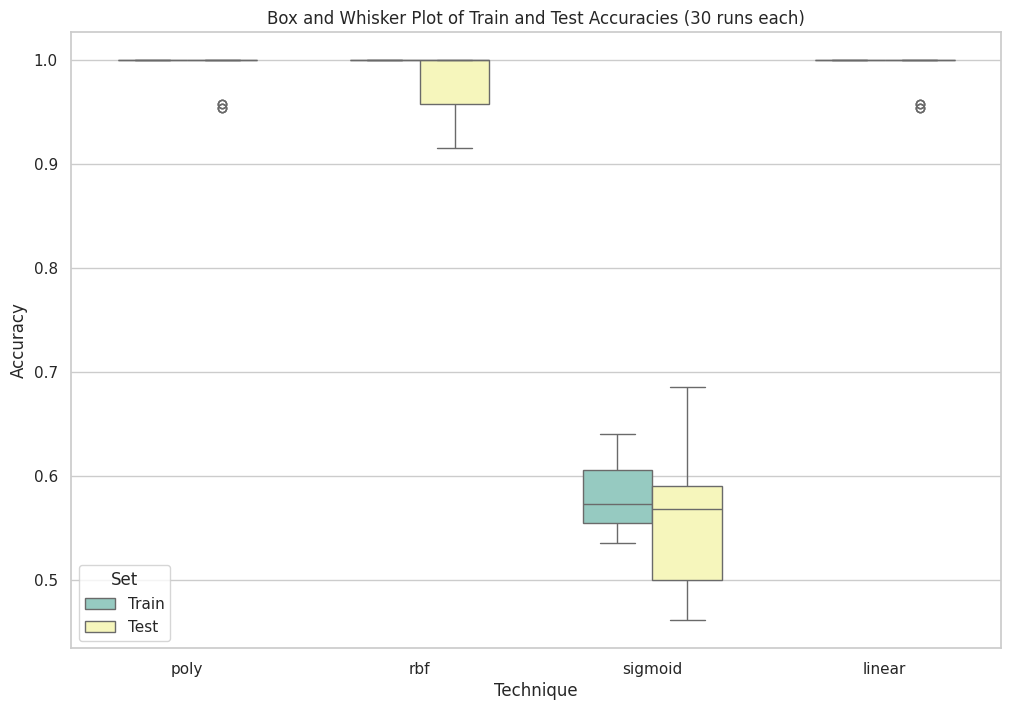

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC as svm

kernels = ['poly', 'rbf', 'sigmoid', 'linear']
results = {'poly': [], 'rbf': [], 'sigmoid': [], 'linear': []}

for _ in tqdm(range(30)):
    for train, test in skf.split(X, y):
        X_train, X_test = (X.iloc[train], X.iloc[test])
        y_train, y_test = y[train], y[test]
        X_train, X_test = normalize(X_train, X_test)

        for kernel in kernels:
            model = svm(kernel=kernel)
            clf = model.fit(X_train, y_train)
            y_predict = model.predict(X_train)
            train_acc = balanced_accuracy_score(y_train, y_predict)
            y_predict = model.predict(X_test)
            test_acc = balanced_accuracy_score(y_test, y_predict)
            results[kernel].append((train_acc, test_acc))

show_results(results, label='kernel')
boxplot_results(results)

[INFO] Reading the dataset.


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]




+------------+------------+-----------+-----------+----------+
| Classifier | Train Mean | Train Std | Test Mean | Test Std |
+------------+------------+-----------+-----------+----------+
|    knn     |   0.9699   |   0.0063  |   0.9501  |  0.0503  |
|     rf     |   1.0000   |   0.0000  |   0.9841  |  0.0242  |
|     dt     |   1.0000   |   0.0000  |   0.9920  |  0.0164  |
|     nb     |   0.9285   |   0.0315  |   0.8928  |  0.0718  |
|    svm     |   0.9875   |   0.0038  |   0.9814  |  0.0280  |
+------------+------------+-----------+-----------+----------+


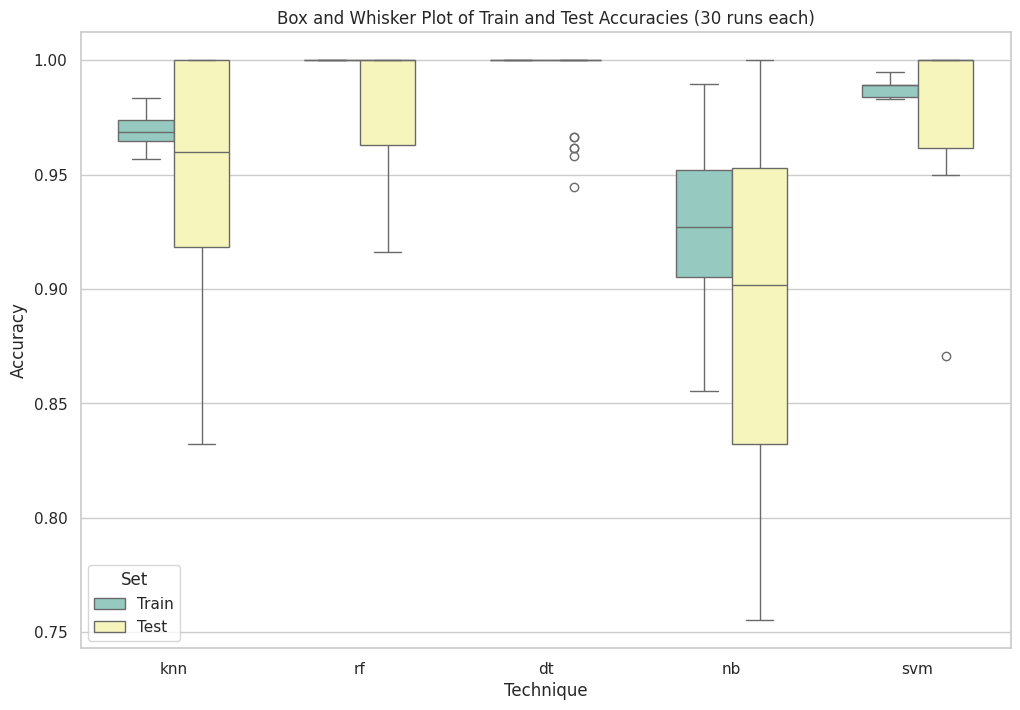

In [11]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
# Binary encoding for the class labels, e.g. 1 for Hoki, 0 for Mackeral.
y = data['m/z'].apply(lambda x: 1 if 'H' in x else 0)
y = np.array(y)

# Evaluation parameters.
train_split = 0.8
val_split = 0.5 # 1/2 of 20%, validation and test, 10% and 10%, respectively.
# print(f"[DEBUG] train_split, val_split, test_split: ({train_split},{val_split},{test_split})")

# Step 2: Split your dataset into training, validation, and testing sets

models = {'knn': knn, 'rf': rf, 'dt': dt, 'nb': nb, 'svm': svm}
results = {'knn': [], 'rf': [], 'dt': [], 'nb': [],'svm': []}

for _ in tqdm(range(30)):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1-train_split))#, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_split)#, random_state=42)
    for name, model in  models.items():
        model = model()
        clf = model.fit(X_train, y_train)
        y_predict = model.predict(X_train)
        train_acc = balanced_accuracy_score(y_train, y_predict)
        y_predict = model.predict(X_test)
        test_acc = balanced_accuracy_score(y_test, y_predict)
        results[name].append((train_acc, test_acc))

show_results(results, label='Classifier')
boxplot_results(results)

In [17]:
# Convert the dictionary to a DataFrame for Seaborn
data = {'Technique': [], 'Accuracy': [], 'Set': []}

for technique, runs in results.items():
    train, test = zip(*runs)
    for run in range(1, 31):  # 30 runs
        data['Technique'].append(technique)
        data['Accuracy'].append(train[run - 1])
        data['Set'].append('Train')

        data['Technique'].append(technique)
        data['Accuracy'].append(test[run - 1])
        data['Set'].append('Test')

df = pd.DataFrame(data)
df.tail()

,Technique,Accuracy,Set
295,svm,1.000000,Test
296,svm,0.994048,Train
297,svm,0.950000,Test
298,svm,0.989216,Train
299,svm,1.000000,Test
